# Probabilistic Expected Utility

In [23]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import pickle
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
from scipy.special import expit
import arviz as az
# multiprocessing.set_start_method("fork")
sns.set()  # Nice plot aesthetic

In [41]:
# Set seed
np.random.seed(123)

The utility of a normalized outcome $x \in [0, 1]$ is defined as:
\begin{equation}
u(x) = x^{1 - \alpha}
\end{equation}

The expected utility of a lottery $L = \{(p_1, x_1), \dots, (p_n, x_n)\}$ is defined as:
\begin{equation}
EU(L) = \sum_{i=1}^{n} p_i u(x_i)
\end{equation}

The probability to choose the lottery $L_k \in \mathcal{L} = \{L_1, \dots, L_{N}\}$ is defined as: 
\begin{equation}
P(L_k) = \frac {e^{EU(L_k) / \tau}}{\sum _{i=1}^{N} e^{EU(L_i) / \tau } }
\end{equation}

### Generate data

Note: We consider here a special case where $L = \{(p, x)\}$ (one lottery has one possible positive output).

In [42]:
# True parameters
alpha_true = 0.3
tau_true = 0.1

# Number of trials
n_trial = 1000

# Number of lottery per trial
n_option = 2

p = np.random.random(size=(n_option, n_trial))
x = np.random.random(size=(n_option, n_trial))

u = x**(1-alpha_true)
eu = p * u

p_choice = np.exp(eu/tau_true)
p_choice /= p_choice.sum(axis=0)

y = np.zeros(n_trial, dtype=int)
for i in range(n_trial):
    y[i] = np.random.choice(np.arange(n_option), p=p_choice[:, i])

Take a look at the data

In [43]:
df_data = pd.merge(
    pd.DataFrame(x.T, columns=[f"x{i}" for i in range(n_option)]), 
    pd.DataFrame(p.T, columns=[f"p{i}" for i in range(n_option)]), left_index=True, right_index=True)
df_data['y'] = y

# n = 100
# df_data = df_data.sample(n=n, replace=False)
# df_data.reset_index(inplace=True, drop=True)

df_data

,x0,x1,p0,p1,y
0,0.423016,0.969426,0.696469,0.081894,0
1,0.393018,0.721784,0.286139,0.495040,1
2,0.036701,0.181892,0.226851,0.288890,1
3,0.884020,0.882028,0.551315,0.639992,0
4,0.676480,0.477022,0.719469,0.499936,0
...,...,...,...,...,...
995,0.610117,0.551774,0.264397,0.193012,0
996,0.621986,0.544699,0.690915,0.731650,0
997,0.208917,0.737517,0.347146,0.274711,1
998,0.567472,0.703100,0.004168,0.721818,1


## Inference using Pymc3

In [44]:
with pm.Model() as model:
    
    # BoundedNormal = pm.Bound(pm.Normal, upper=1)
    # α = BoundedNormal('α', mu=0, sigma=0.1)
        
    # BoundedNormal = pm.Bound(pm.Normal, lower=0)
    # τ = BoundedNormal('τ', mu=0.1, sigma=0.01)
    
    α = pm.Uniform('α', lower=-1, upper=0.5)
    τ = pm.Uniform('τ', lower=0.01)

    eu0_hat = df_data.p0.values * df_data.x0.values**(1-α)
    eu1_hat = df_data.p1.values * df_data.x1.values**(1-α)
    
    diff_eu_hat = eu1_hat - eu0_hat
    
    est_p_choice1 = pm.math.invlogit((1/τ)*diff_eu_hat)
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=df_data.y.values)

In [45]:
with model:
    # trace = pm.find_MAP()
    trace = pm.sample(1000, tune=500, chains=4, return_inferencedata=True, 
                      target_accept=0.90)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 2 jobs)
NUTS: [τ, α]
INFO:pymc3:NUTS: [τ, α]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.


array([<AxesSubplot:title={'center':'α'}>,
       <AxesSubplot:title={'center':'τ'}>], dtype=object)

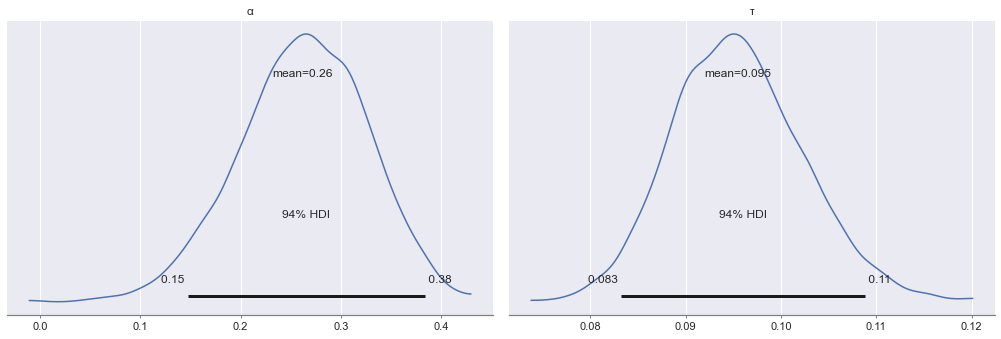

In [46]:
az.plot_posterior(trace, var_names=['α', 'τ'])